In [ ]:
import os
from sklearn.decomposition import PCA
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from umap import UMAP
import warnings
from collections import Counter
# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
SAVE_FIGURE_PATH = '../figures/'
FEATURES_PATH = '../features/'

# Loading the features from the features path
volume_features_path = os.path.join(FEATURES_PATH, 'volume_features.npy')
labels_path = os.path.join(FEATURES_PATH, 'labels.npy')

# Load the extracted features and labels
if os.path.exists(volume_features_path) and os.path.exists(labels_path):
    volume_features = np.load(volume_features_path)
    labels = np.load(labels_path)
else:
    print("Volume features or labels not found")

In [4]:
print("Volume features shape:", volume_features.shape)
print("Labels shape:", labels.shape)

# Get the distribution of the labels
Counter(labels)

Volume features shape: (18426, 512)
Labels shape: (18426,)


Counter({-1.0: 18216,
         1.0: 15,
         3.0: 15,
         4.0: 15,
         8.0: 15,
         10.0: 15,
         11.0: 15,
         0.0: 15,
         12.0: 15,
         5.0: 15,
         6.0: 15,
         13.0: 15,
         2.0: 15,
         7.0: 15,
         9.0: 15})

# PCA

In [10]:
def plot_PCA(features_pca, labels, save_name=None, cmap='hsv', unlabeled=True):
    """
    Create a PCA plot for the given features extracted from the 3D volumes
    :param features_pca: PCA transformed features
    :param labels: list of labels for the features (-1 indicates no label)
    :param save_name: name of the figure to save, if None the figure will be shown
    :param cmap: colormap to use for the labels
    :param unlabeled: if set to False plot just the points with the given label (not -1), otherwise plot all the data points
    """
    
    # Create a copy of the colormap
    base_cmap = plt.cm.get_cmap(cmap, len(np.unique(labels)) - 1)  # -1 because we handle -1 separately
    
    # Create a custom colormap with grey for -1
    colors = np.vstack(
        (np.array([0.5, 0.5, 0.5, 1]),  # Grey for -1
        base_cmap(np.linspace(0, 1, len(np.unique(labels)) - 1))))
    custom_cmap = mcolors.ListedColormap(colors)
    
    # Create a normalized colormap that maps label values to colors
    bounds = np.arange(-1, len(np.unique(labels))) + 0.5
    norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)
    
    # Split the data into labeled and unlabeled
    unlabeled_mask = labels == -1
    labeled_mask = ~unlabeled_mask
    
    plt.figure(figsize=(10, 8))
    
    if unlabeled:
        # Plot also unlabeled points
        if np.any(unlabeled_mask):
            plt.scatter(
                features_pca[unlabeled_mask, 0], 
                features_pca[unlabeled_mask, 1],
                c='black', s=25, alpha=0.2,  # Lower alpha for unlabeled points
                label='Unlabeled'
            )
        
    # Plot labeled points with higher alpha
    if np.any(labeled_mask):
        scatter = plt.scatter(
            features_pca[labeled_mask, 0], 
            features_pca[labeled_mask, 1],
            c=labels[labeled_mask], cmap=base_cmap, norm=norm, s=35, alpha=0.7,  # Higher alpha for labeled points
        )
    
    # Create colorbar with proper ticks (only for labeled data)
    cbar = plt.colorbar(
        scatter, 
        label='Labels', 
        ticks=np.unique(labels[labeled_mask]))
    
    plt.grid()
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('PCA of 3D CNN Features')
    plt.legend()
    
    if save_name:
        # Save the figure
        plt.savefig(os.path.join(SAVE_FIGURE_PATH, save_name))
        print(f"Figure saved as {save_name}")
    else:
        plt.show()

In [6]:
# 3. Use PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
pca.fit(volume_features)
volume_features_pca = pca.transform(volume_features)
print(f"Reduced features shape: {volume_features_pca.shape}")
print(f"Reduced features: {volume_features_pca}")

Reduced features shape: (18426, 2)
Reduced features: [[ 60.23471     25.907135  ]
 [  0.6028099  -39.25985   ]
 [-21.505413    -8.161362  ]
 ...
 [  0.46719742 -38.66436   ]
 [ 33.840065     9.601868  ]
 [-55.81224     54.634506  ]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


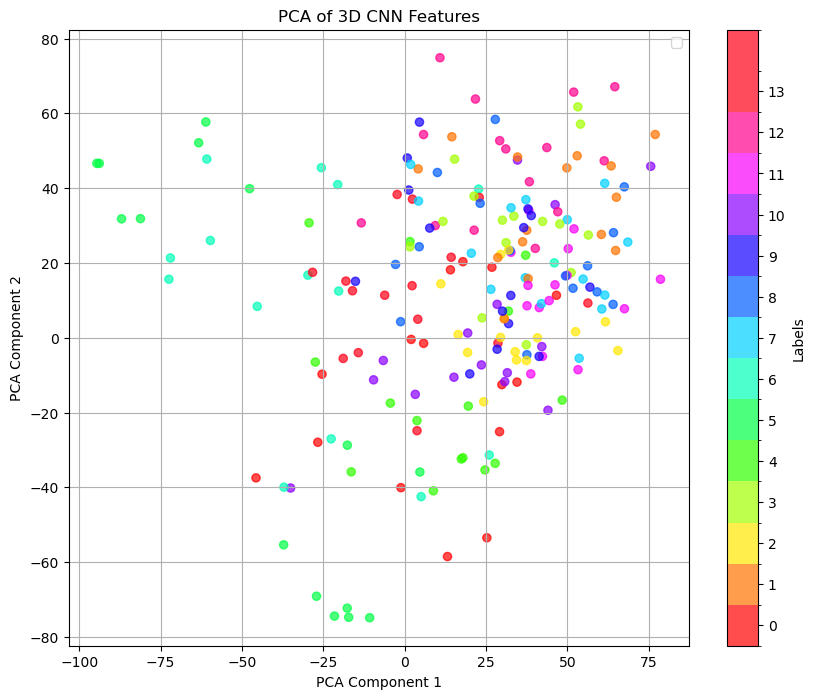

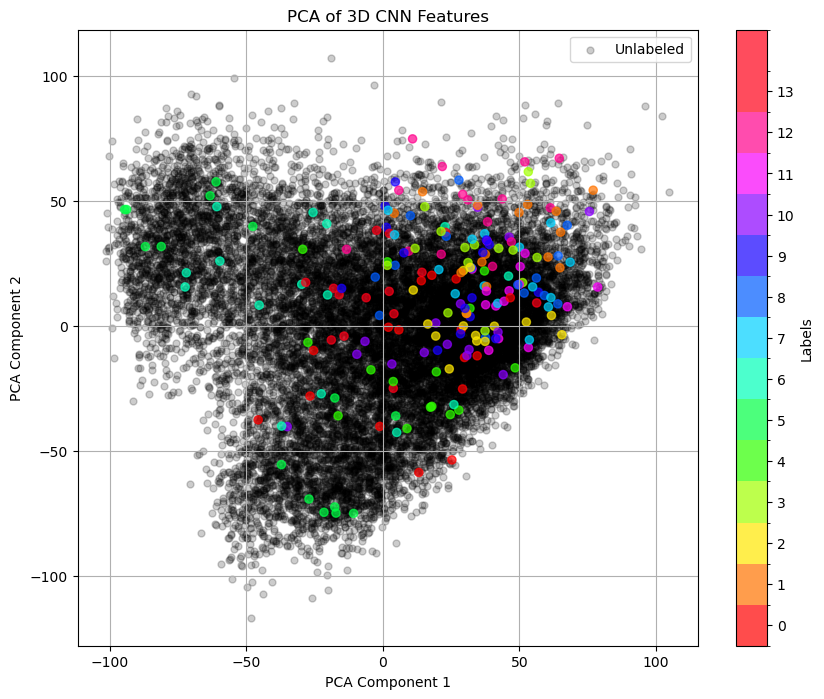

In [11]:
plot_PCA(volume_features_pca, labels, unlabeled=False)
plot_PCA(volume_features_pca, labels, unlabeled=True)

# PCA (keep 95% variance) -> TSNE (2D) -> plot

**t-SNE** is a non-linear dimensionality reduction technique that is particularly well-suited for visualizing high-dimensional data in a low-dimensional space (typically 2D or 3D). It works by converting the similarities between data points into joint probabilities and then minimizing the divergence between these probabilities in the high-dimensional and low-dimensional spaces.
https://distill.pub/2016/misread-tsne/


In [18]:
pca = PCA(n_components=0.90)  # Keep 95% of variance
pca_features = pca.fit_transform(volume_features)
print(f"PCA reduced dimensions from {volume_features.shape[1]} to {pca_features.shape[1]}")

PCA reduced dimensions from 512 to 5


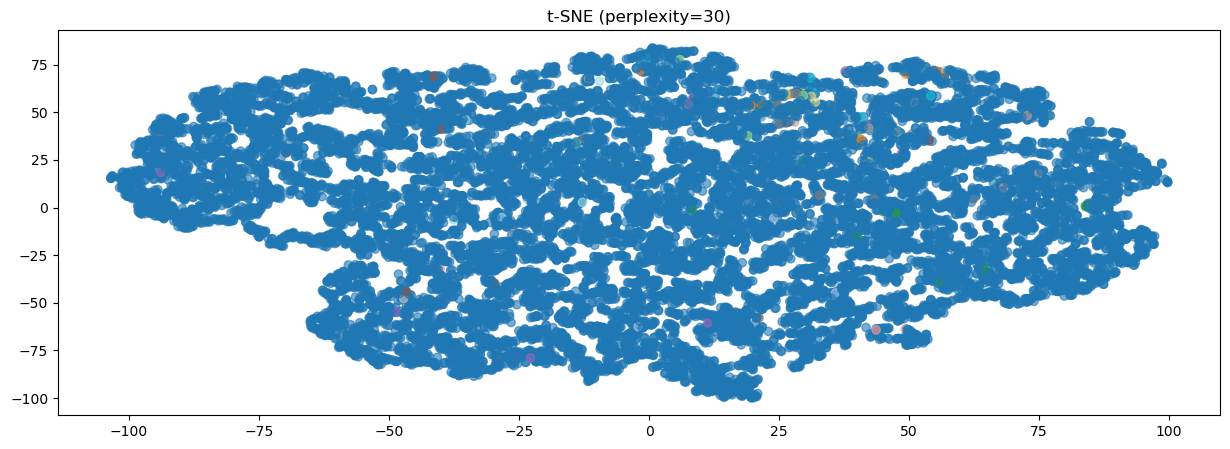

In [20]:
# 2. t-SNE with different parameters
# Perplexities are a hyperparameter for t-SNE that affects the balance between local and global aspects of the data
# perplexities = [5, 30, 50]
perplexities = [30]


fig, axes = plt.subplots(1, len(perplexities), figsize=(15, 5))
if len(perplexities) == 1:
    axes = [axes]  # Make sure axes is iterable

for i, perp in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perp, random_state=42)
    tsne_result = tsne.fit_transform(pca_features)
    scatter = axes[i].scatter(
        tsne_result[:, 0], tsne_result[:, 1], 
        c=labels, alpha=0.6, cmap='tab20')
    axes[i].set_title(f't-SNE (perplexity={perp})')

# UMAP

Uniform Manifold Approximation and Projection for Dimension Reduction

/dtu/3d-imaging-center/courses/conda/miniconda3/envs/env-02510/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/zhome/f3/2/213983/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


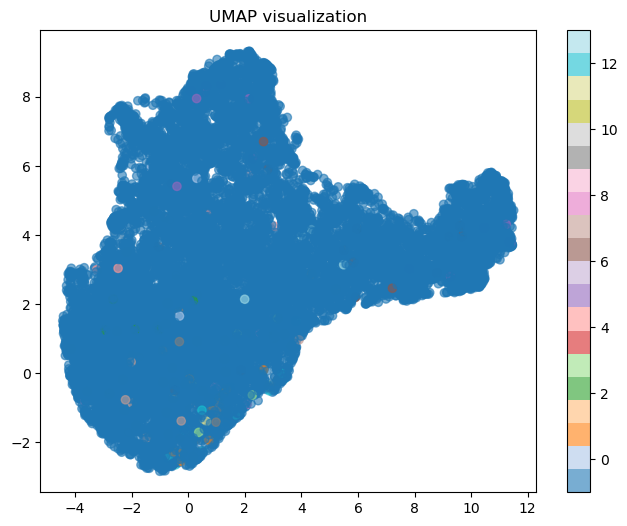

In [ ]:
# 3. UMAP visualization
umap_reducer = UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(volume_features)

# Create a copy of the colormap
cmap = 'hsv'
base_cmap = plt.cm.get_cmap(cmap, len(np.unique(labels)) - 1)  # -1 because we handle -1 separately

# Create a custom colormap with grey for -1
colors = np.vstack(
    (np.array([0.5, 0.5, 0.5, 1]),  # Grey for -1
    base_cmap(np.linspace(0, 1, len(np.unique(labels)) - 1))))
custom_cmap = mcolors.ListedColormap(colors)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    umap_result[:, 0], umap_result[:, 1], 
    c=labels, alpha=0.6, cmap=custom_cmap, s=35)
plt.colorbar(scatter)
plt.title('UMAP visualization')
plt.show()